In this notebook we comapre k-means clustering on CLIP embeddings of a dataset with k-means clustering on the raw pixel features of the images in the Bird dataset. <br>
We hypothesize that in the CLIP space, the clusters formed from the CLIP embeddings will represent semantic similarities in the patterns, e.g., patterns that arise in similar materials,  similar objects  <br>
On the other hand, we expect the clusters formed from the raw pixel vectors to be grouped based on more high-level similarities in the features of the images, e.g., similiarity in the shapes in the pattern no matter the mediums in which the patterns occur, colors, etc. <br> 
(starter code by Dhanashree for the Birds dataset, adapted by Megha and Naomi for Patterns)

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image
import random

## Clustering of CLIP embeddings

In [2]:
# Load patterns_emb. 
patterns_emb = np.load('patterns_emb.npy')

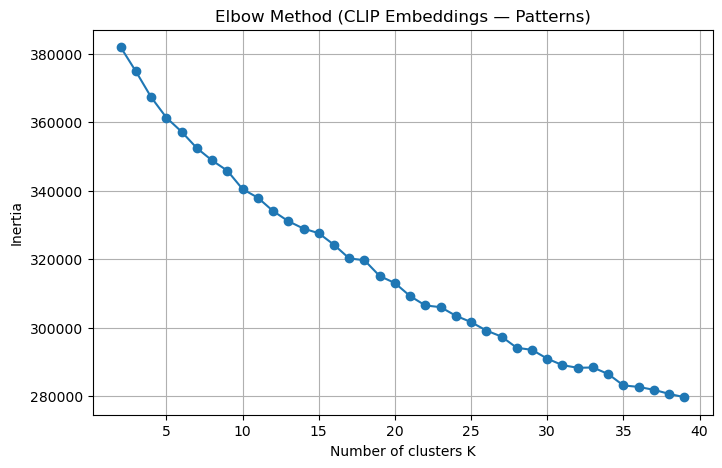

In [3]:
# Plotting Elbow curve to find a god estimate for number of clusters. 
inertias = [] # Sum of squared distances of each data point to its closest cluster center.
K_range = range(2, 40)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(patterns_emb)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method (CLIP Embeddings — Patterns)")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

The graph does not show a clear elbow. So we will use another method to determine the best number of clusters, called the Silhouette Score.

## CONTINUE HERE

K=2, silhouette=0.0328
K=3, silhouette=0.0329
K=4, silhouette=0.0305
K=5, silhouette=0.0319
K=6, silhouette=0.0296
K=7, silhouette=0.0331
K=8, silhouette=0.0344
K=9, silhouette=0.0361
K=10, silhouette=0.0396
K=11, silhouette=0.0391
K=12, silhouette=0.0407
K=13, silhouette=0.0441
K=14, silhouette=0.0467
K=15, silhouette=0.0457
K=16, silhouette=0.0515
K=17, silhouette=0.0531
K=18, silhouette=0.0514
K=19, silhouette=0.0519
K=20, silhouette=0.0543
K=21, silhouette=0.0596
K=22, silhouette=0.0602
K=23, silhouette=0.0607
K=24, silhouette=0.0609
K=25, silhouette=0.0610
K=26, silhouette=0.0639
K=27, silhouette=0.0631
K=28, silhouette=0.0607
K=29, silhouette=0.0636
K=30, silhouette=0.0679
K=31, silhouette=0.0689
K=32, silhouette=0.0671
K=33, silhouette=0.0666
K=34, silhouette=0.0671
K=35, silhouette=0.0669
K=36, silhouette=0.0675
K=37, silhouette=0.0645
K=38, silhouette=0.0654
K=39, silhouette=0.0643
K=40, silhouette=0.0661


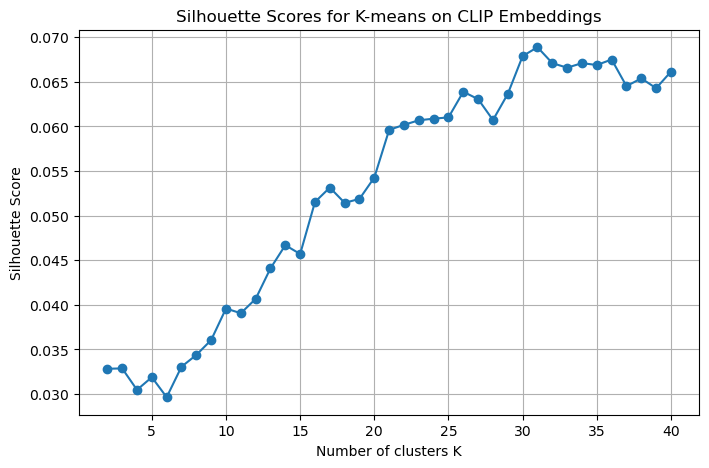

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# embeddings: your (N, D) CLIP embedding matrix
# Ks: the range of cluster numbers
Ks = range(2, 41)
sil_scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(patterns_emb)
    score = silhouette_score(patterns_emb, labels)
    sil_scores.append(score)
    print(f"K={k}, silhouette={score:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(Ks, sil_scores, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for K-means on CLIP Embeddings")
plt.grid(True)
plt.show()


In [23]:
best_k_clip = 30

# Train k-means on CLIP embeddings.
kmeans_clip = KMeans(n_clusters=best_k_clip, random_state=0)
clip_clusters = kmeans_clip.fit_predict(patterns_emb)

## Clustering for Pixel space 

In [24]:
# Same function as seen in the main notebook. 
def get_all_images_pathlib(root_folder):
    root_path = Path(root_folder)
    images = []
    
    for file_path in root_path.rglob('*'):
        if file_path.suffix.lower() == '.jpg':
            images.append(str(file_path))
    
    return images

In [25]:
base_dir = '/home/n2ortega/'
patterns_folder = f'{base_dir}COGS118B_FinalProject/Patterns'
patterns = get_all_images_pathlib(patterns_folder)
print(f"Found {len(patterns)} images")

Found 1392 images


In [26]:
def load_pixel_vectors(image_paths, size=(128,128)):
    pixel_vectors = []
    for p in image_paths:
        img = Image.open(p).convert("RGB").resize(size)
        arr = np.array(img).flatten()
        pixel_vectors.append(arr) # Add the vector for each image.
    return np.array(pixel_vectors)

pixel_data = load_pixel_vectors(patterns) # This contains the pixel data for the Patterns images. 
print("Pixel data shape:", pixel_data.shape)

Pixel data shape: (1392, 49152)


In [27]:
# Reduce the dimentionality of the pixel features using PCA.
# WHY IS THIS IMPORTANT? -> Makes the clusters more stable.
# The sklearn documentation also mentions that for very high dimensionality, k-means performance is impacted. 
# We do not resize to a very small size to preserve the details of the image. 

pca_pixels = PCA(n_components = 50)   
pixel_pcs = pca_pixels.fit_transform(pixel_data)

print("PCA pixel feature shape:", pixel_pcs.shape)

PCA pixel feature shape: (1392, 50)


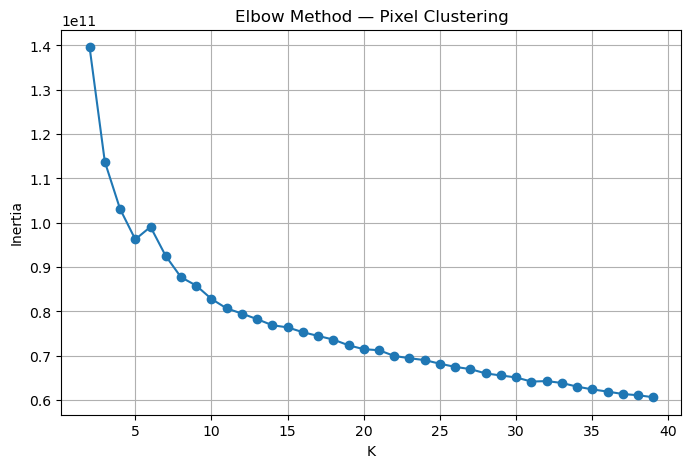

In [28]:
# Plot the elbow curve
# Similar to what we did earlier.

K_range = range(2, 40)
inertias = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pixel_pcs)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method — Pixel Clustering")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

##### From this graph we see that about **20** is a good estimate for the number of clusters. 

In [30]:
best_k_pixel = 20

# Train k-means on pixel data.
kmeans_pixel = KMeans(n_clusters=best_k_pixel, random_state=0)
pixel_clusters = kmeans_pixel.fit_predict(pixel_data)

In [ ]:
# We would like to see how the pattern images were grouped differently.
# To do this we define a function which lets us display "n" number of images from a cluster of or choice.
# We refer to a cluster by its number. 

In [ ]:
def show_cluster_samples(image_paths, labels, cluster_id, n=20):
    
    idx = [i for i in range(len(labels)) if labels[i] == cluster_id] # Get the indexes of images in a cluster. 
    # Here label is the cluster number assigned to an image. 
    # cluster_id is the cluster we want to look into. 
    # This works because CLIP embeddings retain the original ordering of images. So we can correlate this to the original images. 
    
    if len(idx) == 0: 
        print("cluster empty") # If we try to check a cluster that doesn't exist.
        return
    
    sample = random.sample(idx, min(n, len(idx))) # Randomly selecting indexes of images in a cluster.

    # Set style specifics for the plot of images. 
    cols = 4  
    rows = (len(sample) + cols - 1) // cols 
    plt.figure(figsize=(10, 10))
    
    for j, i in enumerate(sample):
        img = Image.open(image_paths[i]).convert("RGB")
        ax = plt.subplot(rows, cols, j+1)
        plt.imshow(img) # Display the images. 
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# example clusters
clip_k = 10      # Pick any valid cluster number from clip clusters (1 to 20).
pixel_k = 9    # Pick any valid cluster number from pixel clusters (1 to 16).

print("CLIP cluster:")
show_cluster_samples(patterns, clip_clusters, clip_k, n=15)

print("Pixel cluster:")
show_cluster_samples(patterns, pixel_clusters, pixel_k, n=15)


In [ ]:
# example clusters
clip_k = 5      # Pick any valid cluster number from clip clusters.
pixel_k = 7    # Pick any valid cluster number from pixel clusters.

print("CLIP cluster:")
show_cluster_samples(patterns, clip_clusters, clip_k, n=15)

print("Pixel cluster:")
show_cluster_samples(patterns, pixel_clusters, pixel_k, n=15)


In [ ]:
# example clusters
clip_k = 18     # Pick any valid cluster number from clip clusters (1 to 20).
pixel_k = 3    # Pick any valid cluster number from pixel clusters (1 to 10).

print("CLIP cluster:")
show_cluster_samples(patterns, clip_clusters, clip_k, n=15)

print("Pixel cluster:")
show_cluster_samples(patterns, pixel_clusters, pixel_k, n=15)


CLIP cluster:


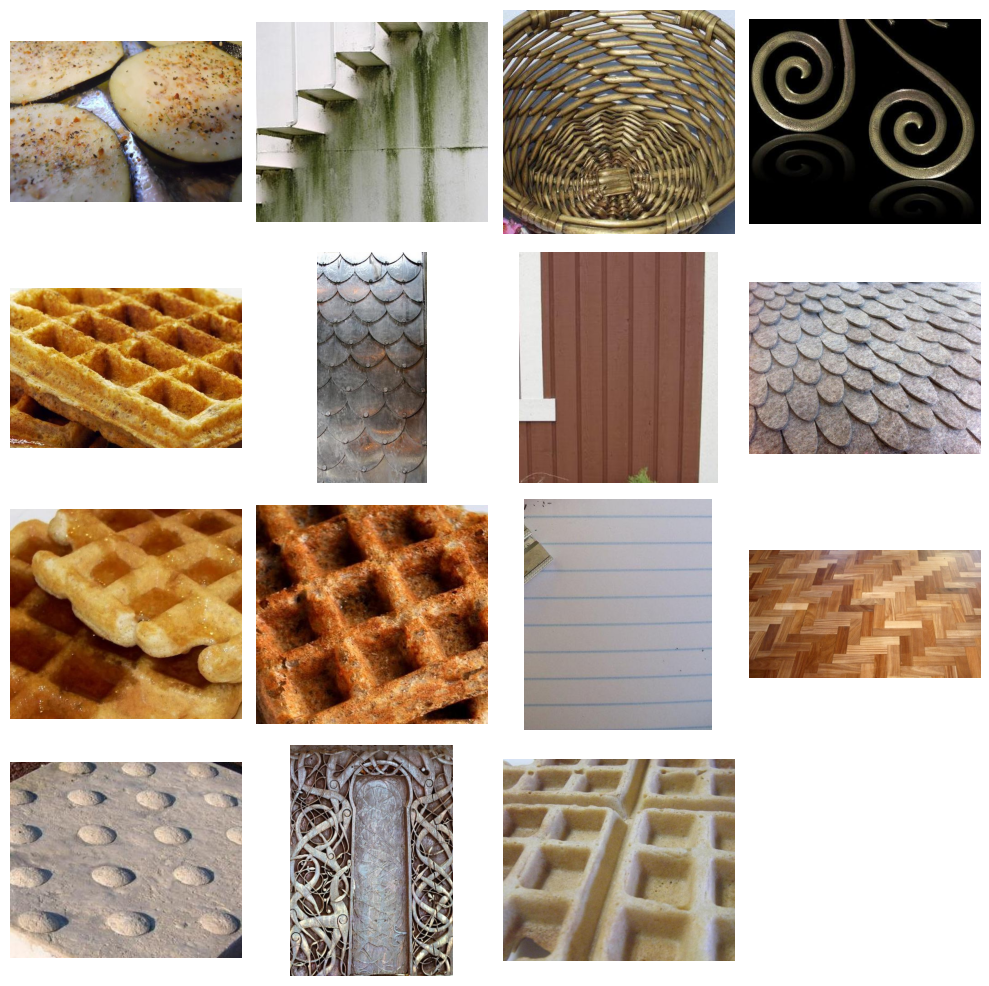

Pixel cluster:


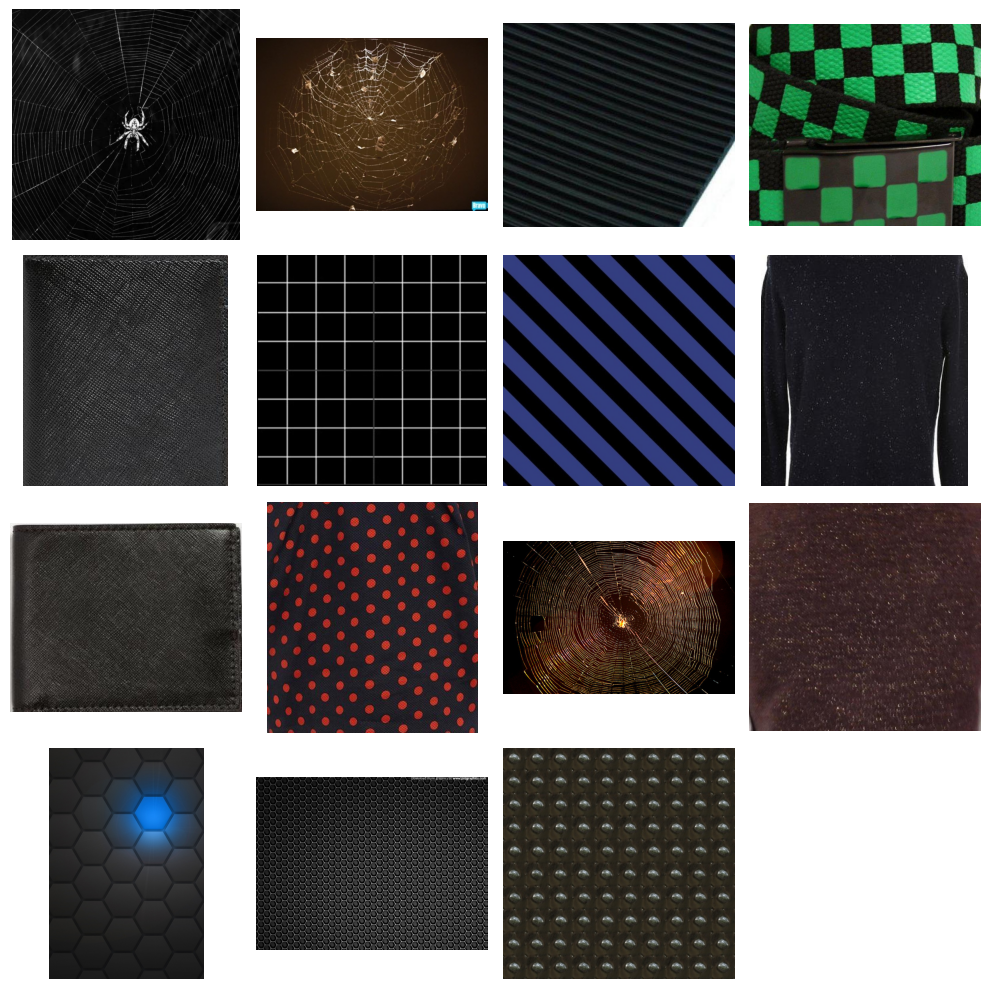

In [16]:
# example clusters
clip_k = 7    # Pick any valid cluster number from clip clusters (1 to 20).
pixel_k = 15    # Pick any valid cluster number from pixel clusters (1 to 10).

print("CLIP cluster:")
show_cluster_samples(patterns, clip_clusters, clip_k, n=15)

print("Pixel cluster:")
show_cluster_samples(patterns, pixel_clusters, pixel_k, n=15)


## Observations (EDIT)

We looked at several clusters from both the CLIP‑based clustering and the pixel‑based clustering to see how the images were grouped. We have displayed 4 such cluster pairs above. <br>
Overall, the CLIP clusters grouped together patterns that looked similar in terms of species and shape. <br>
In contrast, the pixel clusters grouped images more randomly with a variety of patterns being grouped together. The images could be similar on more hgih-level features of the images like the most dominant colors in them or the lighting and brightness in the images. <br>
It appears that CLIP clustering captured more meaningful bird similarities, while pixel clustering was mostly influenced by low‑level visual details.